##План работы

### 1. Выбор фреймворка/библиотеки для использования детектора (1 балл)

Чтобы освежить память о задаче детекции, можно посмотреть [занятия на продвинутом курсе](https://stepik.org/lesson/458312/step/1?unit=616130).

В выборе фреймворка предоставляется свобода, лично я рекомендовал бы один из:
- `torchvision.models.detection` и `torchhub`: "нативные" модели для детектирования прямо из PyTorch. Примеры использования есть прямо на занятиях DLSchool по практике CV [2019 года](https://www.youtube.com/watch?v=XSPYe4-y4HE) и [2020 года](https://stepik.org/lesson/458313/step/1?unit=616131);
- `mmdetection`: как с ним работать, рассказывается в [практическом занятии](https://stepik.org/lesson/458313/step/2?unit=616131).
- `detectron2`: краткая информация есть в конце [занятия DLSchool по практике CV](https://www.youtube.com/watch?v=XSPYe4-y4HE), можно начать с него. Лучше самостоятелньо изучить [официальный репозиторий](https://github.com/facebookresearch/detectron2) и уже с ним работать в дальнейшем ("Quick Start");
- `TensorFlow Object Detection API`: как с ним работать рассказывается в [занятии 2018 года](https://www.youtube.com/watch?v=xHIzyrU1uVM). Работать предстоит с [официальным репозиторием](https://github.com/tensorflow/models/tree/master/research/object_detection).

**Обратите внимание, что для получения полного балла по проекту необходимо обучить и сравнить как минимум две различные модели детекции (можно из одного фреймворка)!**

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from xml.etree import ElementTree as et

import torch
import torchvision
from torchvision import ops
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import ssd300_vgg16
from torchvision import transforms

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import train_test_split

import time
import argparse
from PIL import Image
from google.colab.patches import cv2_imshow
import skimage
from skimage import io
from PIL import Image
from urllib.request import urlopen

%matplotlib inline

print(torch.__version__)

2.0.1+cu118


In [ ]:
%%bash
pip install numpy scipy scikit-image matplotlib

In [ ]:
!pip install -U torchmetrics
from torchmetrics.detection.mean_ap import MeanAveragePrecision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.8/728.8 kB 36.2 MB/s eta 0:00:00


In [ ]:
# defenition of the models
model_fasterrcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_ssd300 = ssd300_vgg16(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 289MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None

In [ ]:
# # model architecture
# model_fasterrcnn

In [ ]:
# # model architecture
# model_ssd300

###2. Запуск детектора на случайных изображениях (1 балл)

В этом пункте вам необходимо применить модель детектирования в выбранном выше репозитории (по сути проверить, что инференс в модели работает). Таким образом, вы убедитесь, что модель работает, и сможет переходить к обучению.

> Результатом пункта явлется набор изображений, на которых модель успешно отработала и результат детекции виден и понятен.

In [ ]:
#trained classes on the model
coco_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [ ]:
# this will help us create a different color for each class
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))

In [ ]:
# define the torchvision image transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [ ]:
def predict(image, model, device, detection_threshold):
    # transform the image to tensor
    image = transform(image).to(device)
    image = image.unsqueeze(0) # add a batch dimension
    outputs = model(image) # get the predictions on the image
    # get all the predicited class names
    pred_classes = [coco_names[i] for i in outputs[0]['labels'].cpu().numpy()]
    # get score for all the predicted objects
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    # get all the predicted bounding boxes
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    # get boxes above the threshold score
    boxes = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32)
    return boxes, pred_classes, outputs[0]['labels']

In [ ]:
#Here, we will write the draw_boxes() function. This function will draw a bounding box around each of the object that we detect in an image.
def draw_boxes(boxes, classes, labels, image):
    # read the image with OpenCV
    image = cv2.cvtColor(np.asarray(image), cv2.COLOR_BGR2RGB)
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[i], (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return image

In [ ]:
#url of picture
url = 'http://farm5.staticflickr.com/4013/4586522886_6cb17e0c32_z.jpg'

In [ ]:
with Image.open(urlopen(url)) as img:
    img.save('elephant.png')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

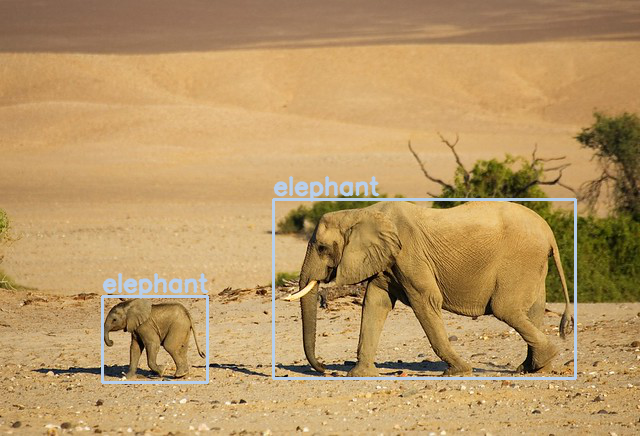

In [ ]:
# FASTERRCNN prediction
imag = Image.open('/content/elephant.png')
model_fasterrcnn.eval().to(device)
boxes, classes, labels = predict(imag, model_fasterrcnn, device, 0.8)
image = draw_boxes(boxes, classes, labels, imag)
cv2_imshow( image)

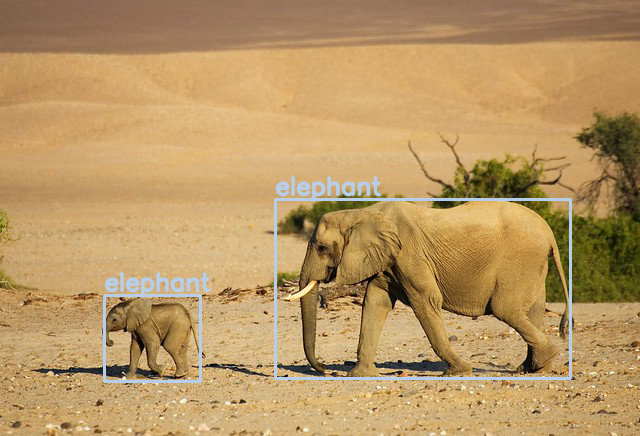

In [ ]:
# SSD prediction
model_ssd300.eval().to(device)
boxes, classes, labels = predict(imag, model_ssd300, device, 0.8)
image = draw_boxes(boxes, classes, labels, imag)
cv2_imshow( image)

### 3. Выбор датасета (0 баллов)

Вы можете выбрать любой датасет для детекции. Вот несколько идей:
1. [Детекция игровых карт](https://github.com/EdjeElectronics/TensorFlow-Object-Detection-API-Tutorial-Train-Multiple-Objects-Windows-10): лежат в папке images вместе с разметкой;
2. [Детекция фруктов](https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection): скачать можно, нажав на кнопку Download;
3. [Детекция одежды (Deep Fashion 2)](https://github.com/switchablenorms/DeepFashion2): стоит прочитать README на главной странице репозитория. Для получения датасета нужно запросить пароль у автора через гугл-форму. После скачивания распакуйте его с использованием пароля. Из файлов аннотаций нас будут интересовать только `bounding_box`, `category_name` и `category_id`;
4. [Детекция лиц (Wider Face)](http://shuoyang1213.me/WIDERFACE/): большой датасет для детектирования лиц самых разных размеров. Скачать можно прямо по ссылкам на сайте;
5. [Детекция лиц (Kaggle)](https://www.kaggle.com/dataturks/face-detection-in-images): в датасете достаточно мало данных, но можно попробовать, если датасеты выше показались неподходящими для Вас;
6. Датасет из любого соревновани по детекции на Kaggle.

При работе с датасетом вы неизбежно столкнетесь с работой с файлами и папками (директориями). Рекомендуется освежить в памяти работу с библиотеками `os`, `json`, `glob`. Может помочь [этот туториал](https://realpython.com/working-with-files-in-python/).

> Результатом выполнения пункта явлется загруженный датасет, состоящий из изображений и разметки к ним (bounding box'ов всех объектов на каждом изображении).


In [ ]:
!wget -c https://www.dropbox.com/s/ca6kdg4go284uxg/fruit.zip?dl=0

--2023-07-09 13:12:09--  https://www.dropbox.com/s/ca6kdg4go284uxg/fruit.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/ca6kdg4go284uxg/fruit.zip [following]
--2023-07-09 13:12:09--  https://www.dropbox.com/s/raw/ca6kdg4go284uxg/fruit.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc88ff171ad0c1836b5e58a7f6ac.dl.dropboxusercontent.com/cd/0/inline/B_iogRE1YG_-MDRMCpnFhXFbZNbOwhfBnqlFdaLIV-PaWZzqnFAoD3mjcCM2npXSqHXNXJbmLU602D7NS9aW8SehDpcF99mlq-5C5NERB61aek7erNyXjkJ_F45ri-2qcJXGARBox31RU1RXrZIhSAEPluZNI7XDRBKiTM3w2f0o3g/file# [following]
--2023-07-09 13:12:09--  https://uc88ff171ad0c1836b5e58a7f6ac.dl.dropboxusercontent.com/cd/0/inline/B_iogRE1YG_-MDRMCpnFhXFbZNbOwhfBnqlFdaLIV-PaWZzqnFAoD3mjcCM2npXSqHXNXJbmLU602D7NS9aW

In [ ]:
!unzip -q /content/fruit.zip?dl=0 -d fruit

### 4. Предобработка данных (2 балла)

Самый непростой этап в этом сценарии. Скачать данные $-$ лишь половина дела. Чтобы обучить нейросеть на этих данных, нужно написать генератор батчей. Однако если будем подавать изображения так, как они есть, то даже батч собрать не сможем -- нужно привести их к однмоу размеру. Далее нужно привести их к типу float, переместить на CUDA и поделить значения в пикселях на 255 (подробнее см. [занятие](https://www.youtube.com/watch?v=XSPYe4-y4HE)). Также нужно настроить аугментации и постобработку.

То, как именно все это реализовать $-$ зависит от инструмента, выбранного в пункте 1. Например, в detectron2 в обучающих материалах описан формат данных для обучения. Возможно, нужно будет зайти в документацию и почитать более подробно, чтобы разобраться, какой именно нужен формат координат.

НЕ нужно копировать все файлы с картинками и разметкой прямо на диске в их предобработанные версии. Хороший тон $-$ осуществлять всю эту обработку программно, "на лету". Поможет [туториал](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) по написанию своего датасета на PyTorch.

> Результатом выполнения пункта явлется код, запуск которого ведет к подаче батчей правильного вида (разметка приведена к требуемому формату координат, изображения нужного типа, размера и поделены на 255 и т.д.) для обучения нейронной сети-детектора.

In [ ]:
class FruitImagesDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width

        self.imgs = [image for image in sorted(os.listdir(files_dir))  #list of sorted files '.jpg'
                        if image[-4:]=='.jpg']

        self.classes = [_, 'apple','banana','orange']   # first class is mixe of fruits

    def __getitem__(self, idx):
        img_name = self.imgs[idx] #files from the list are taken alternately
        image_path = os.path.join(self.files_dir, img_name) # full name of file

        img = cv2.imread(image_path)# reading file
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)# from BGR to RGB
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)# resize

        img_res /= 255.0

        annot_filename = img_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.files_dir, annot_filename)

        boxes = []
        labels = []

        tree = et.parse(annot_file_path)
        root = tree.getroot()

        wt = img.shape[1] # the width of the original image
        ht = img.shape[0] # the height of the original image

        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text)) #defenition of the class

            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text) # box coordinates

            xmin_corr = (xmin/wt)*self.width # new coordinates of the boxes
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height

            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        if self.transforms:
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return img_res, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
def get_model(num_classes, modelName):

    # Loading the pre-trained model
    if modelName == 'fasterrcnn':
        model = fasterrcnn_resnet50_fpn(pretrained=True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        return model

    if modelName == 'SSD_300':
        model = ssd300_vgg16(pretrained = True)
        from torchvision.models.detection.ssd import SSDClassificationHead
        anchors = model.anchor_generator.num_anchors_per_location()
        out_channels = [512, 1024, 512, 256, 256, 256]
        model.head.classification_head = SSDClassificationHead(out_channels, anchors, num_classes)
        return model

def collate_fn(batch):
    return tuple(zip(*batch))

def get_transform(train):
    if train:
        return A.Compose([
            A.HorizontalFlip(0.5),
            A.VerticalFlip(0.3),
            ToTensorV2(p=1.0)
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
            ToTensorV2(p=1.0)
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
import matplotlib.patches as patches

def plot_img_bbox(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    if isinstance(img, torch.Tensor): # checks whether img belongs to the torch class.Tensor
        img = transforms.ToPILImage()(img).convert('RGB')
    a.imshow(img)

    boxes = target['boxes']
    if isinstance(boxes, torch.Tensor):
        boxes = boxes.tolist()

    for box in (boxes):
        x, y, width, height = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')
        a.add_patch(rect)

    plt.show()

In [ ]:
files_dir = 'fruit//train_zip/train'
test_dir = 'fruit//test_zip/test'

dataset = FruitImagesDataset(files_dir, 224, 224)
print('length of dataset = ', len(dataset), '\n')

length of dataset =  240 



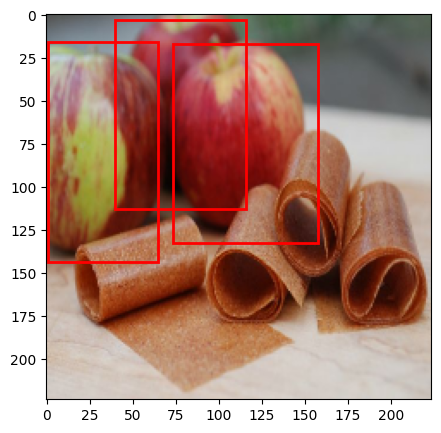

In [ ]:
img, target = dataset[2]
plot_img_bbox(img, target)

In [ ]:
def form_dataset(width):
  dataset = FruitImagesDataset(files_dir, width, width, transforms=get_transform(train=True))
  dataset_test = FruitImagesDataset(test_dir, width, width, transforms=get_transform(train=False))
  print('length of dataset = ', len(dataset_test), '\n')

  return dataset, dataset_test

In [ ]:
def form_loader(dataset,dataset_test ):
  train_data, val_data = train_test_split(dataset, test_size=0.1, random_state=101)

  train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=5, shuffle=True, num_workers=2,
    collate_fn=collate_fn)

  val_loader = torch.utils.data.DataLoader(
      val_data, batch_size=5, shuffle=True, num_workers=2,
      collate_fn=collate_fn)

  test_loader = torch.utils.data.DataLoader(
      dataset_test, batch_size=5, shuffle=False, num_workers=2,
      collate_fn=collate_fn)

  return train_loader, val_loader, test_loader

### 5. Обучение моделей-детекторов (3 балла)

Необходимо написать цикл обучения на PyTorch самостоятельно -- это основной критерий в этом пункте. Необходимо обучить обе выбранные модели.

> Результатом выполнения пункта явлется код, запуск которого ведет к обучению модели на выбранном датасете. При обучении **обязательно выводить числовые значения лосса на трейне и валидации**, крайне желательно использовать [`TensorBoard`](https://pytorch.org/docs/stable/tensorboard.html) для визуализации. Обязательно также сохранять модель после каждой N-ой эпохи, чтобы потом ее качество можно было проверить и веса были переиспользуемыми.

#### FASTER_RCNN training

length of dataset =  60 



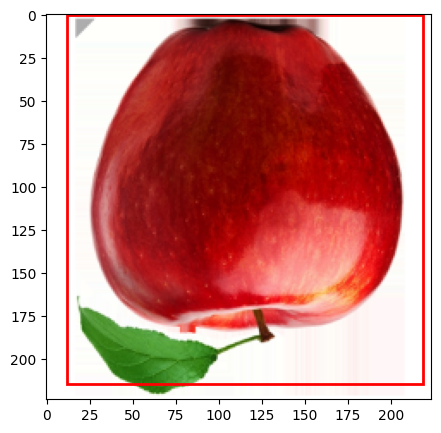

In [ ]:
dataset_RCNN, dataset_test_RCNN = form_dataset(224)
img, target = dataset_RCNN[0]
plot_img_bbox(img, target)

In [ ]:
train_loader_RCNN, val_loader_RCNN, test_loader_RCNN = form_loader(dataset_RCNN, dataset_test_RCNN)

In [ ]:
n_batches, n_batches_test = len(train_loader_RCNN), len(val_loader_RCNN)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 4
modelName = 'fasterrcnn'
model_RCNN = get_model(num_classes, modelName)
model_RCNN.to(device)
learning_rate = 1e-4
optimizer = torch.optim.Adam(model_RCNN.parameters(), lr=learning_rate, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
def train_model(model, data_loader=None,val_loader=None, num_epoch=10):
    metric = MeanAveragePrecision()
    loss_accum_list = []
    map_list = []
    for epoch in range(1, num_epoch + 1):
        print(f"Starting epoch {epoch} of {num_epoch}")
        time_start = time.time()
        loss_accum = 0.0
        model.train()

        for batch_idx, (images, targets) in enumerate(data_loader, 1):
            # Predict
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Logging
            loss_accum += loss.item()

        lr_scheduler.step()

        # Train losses
        train_loss = loss_accum / n_batches
        loss_accum_list.append(train_loss)

        elapsed = time.time() - time_start
        torch.save(model.state_dict(), f"pytorch_model-e{epoch}.bin")
        prefix = f"[Epoch {epoch:2d} / {num_epoch:2d}]"
        print(f"{prefix} Train loss: {train_loss:7.3f} [{elapsed:.0f} secs]", end=' | ')

        preds_single = []
        targets_single = []

        for batch_idx, (images, targets) in enumerate(val_loader, 1):

            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            targets_single.extend(targets)

            model.eval()
            with torch.no_grad():
                pred = model(images)

            preds_single.extend(pred)

        metric.update(preds_single, targets_single)
        batch_map = metric.compute()
        map_list.append(batch_map['map'])
        print(f"Val mAP: {batch_map['map']}")

    return model, loss_accum_list, map_list

In [ ]:
# Output of the history of error functions and metrics on training and validation samples
def plot_history(train_loss, map_list):
    plt.figure(figsize=(16,9))
    plt.grid(True)
    plt.plot(train_loss, label='Train loss')
    plt.plot(map_list, label='map_list')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

In [ ]:
num_epoch = 12
model_RCNN, train_loss_RCNN, map_list_RCNN = train_model(model_RCNN, train_loader_RCNN, test_loader_RCNN, num_epoch)

Starting epoch 1 of 12
[Epoch  1 / 12] Train loss:   0.400 [41 secs] | Val mAP: 0.36513644456863403
Starting epoch 2 of 12
[Epoch  2 / 12] Train loss:   0.239 [41 secs] | Val mAP: 0.4080564081668854
Starting epoch 3 of 12
[Epoch  3 / 12] Train loss:   0.191 [40 secs] | Val mAP: 0.424885094165802
Starting epoch 4 of 12
[Epoch  4 / 12] Train loss:   0.145 [41 secs] | Val mAP: 0.45092207193374634
Starting epoch 5 of 12
[Epoch  5 / 12] Train loss:   0.121 [41 secs] | Val mAP: 0.4807036221027374
Starting epoch 6 of 12
[Epoch  6 / 12] Train loss:   0.114 [41 secs] | Val mAP: 0.4989759624004364
Starting epoch 7 of 12
[Epoch  7 / 12] Train loss:   0.102 [42 secs] | Val mAP: 0.5138195157051086
Starting epoch 8 of 12
[Epoch  8 / 12] Train loss:   0.100 [41 secs] | Val mAP: 0.5249117612838745
Starting epoch 9 of 12
[Epoch  9 / 12] Train loss:   0.101 [41 secs] | Val mAP: 0.533408522605896
Starting epoch 10 of 12
[Epoch 10 / 12] Train loss:   0.099 [42 secs] | Val mAP: 0.5412338376045227
Starting 

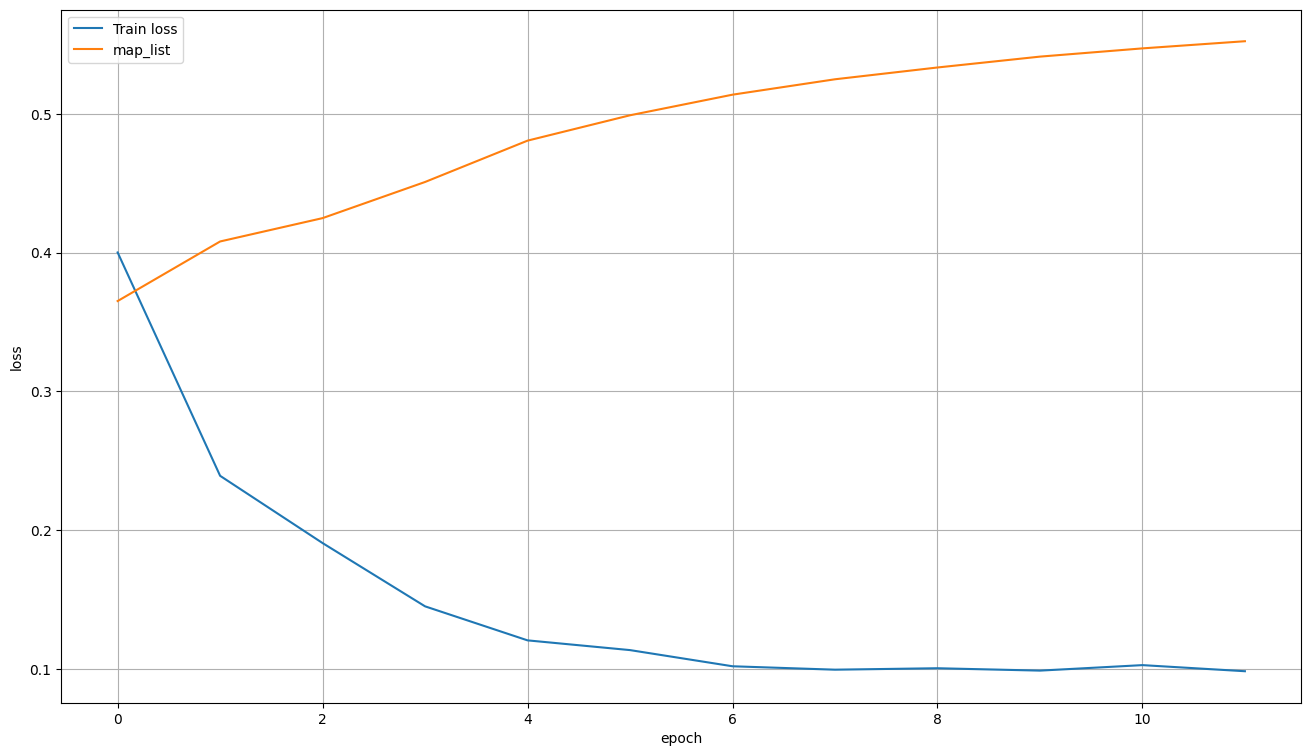

In [ ]:
plot_history(train_loss_RCNN, map_list_RCNN)

In [ ]:
def metric_test(model, test_loader):
    metric = MeanAveragePrecision()

    preds_single = []
    targets_single = []

    for batch_idx, (images, targets) in enumerate(test_loader, 1):

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        targets_single.extend(targets)

        model.eval()
        with torch.no_grad():
            pred = model(images)

        preds_single.extend(pred)

    metric.update(preds_single, targets_single)
    test_map = metric.compute()

    print(f"Test mAP: {test_map['map']}")

In [ ]:
metric_test(model_RCNN, test_loader_RCNN)

Test mAP: 0.6094443798065186


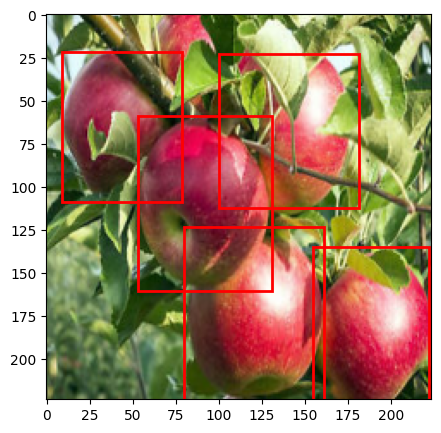

In [ ]:
images, targets = next(iter(test_loader_RCNN))
plot_img_bbox(images[0], targets[0])

In [ ]:
def apply_threshold(prediction,threshold=0.15):
    index = prediction['scores'] > threshold
    pred = prediction.copy()
    pred['boxes'] = pred['boxes'][index]
    pred['scores'] = pred['scores'][index]
    pred['labels'] = pred['labels'][index]

    return pred

def apply_threshold_batch(prediction,threshold=0.15 ):
    preds = []

    for data in prediction:
        preds.append(apply_threshold(data, threshold))

    return preds

In [ ]:
model_RCNN.to(device)
model_RCNN.eval()
with torch.no_grad():
    prediction_RCNN = model_RCNN([images[0].to(device)])

In [ ]:
filtered_preds = apply_threshold_batch(prediction_RCNN, threshold=0.8)

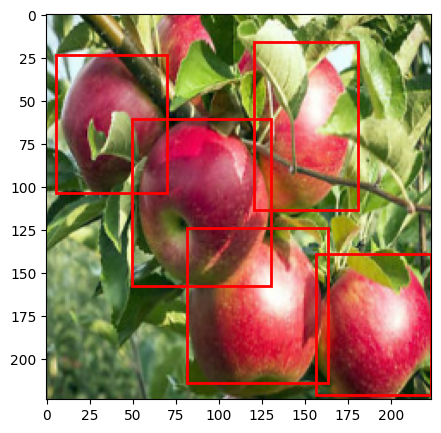

In [ ]:
plot_img_bbox(images[0], filtered_preds[0])

#### SSD_300 training

In [ ]:
dataset_SSD, dataset_test_SSD = form_dataset(300)
train_loader_SSD, val_loader_SSD, test_loader_SSD = form_loader(dataset_SSD, dataset_test_SSD)

length of dataset =  60 



In [ ]:
modelName = 'SSD_300'
model_ssd = get_model(num_classes, modelName)
model_ssd.to(device)
learning_rate = 1e-4
optimizer = torch.optim.Adam(model_ssd.parameters(), lr=learning_rate, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
num_epoch = 12
model_ssd, train_loss_ssd, map_list_ssd = train_model(model_ssd, train_loader_SSD, test_loader_SSD, num_epoch)

Starting epoch 1 of 12
[Epoch  1 / 12] Train loss:   7.105 [9 secs] | Val mAP: 0.14503763616085052
Starting epoch 2 of 12
[Epoch  2 / 12] Train loss:   4.505 [9 secs] | Val mAP: 0.16402307152748108
Starting epoch 3 of 12
[Epoch  3 / 12] Train loss:   3.338 [9 secs] | Val mAP: 0.22213499248027802
Starting epoch 4 of 12
[Epoch  4 / 12] Train loss:   2.480 [9 secs] | Val mAP: 0.2671671509742737
Starting epoch 5 of 12
[Epoch  5 / 12] Train loss:   2.175 [9 secs] | Val mAP: 0.3067913055419922
Starting epoch 6 of 12
[Epoch  6 / 12] Train loss:   1.992 [9 secs] | Val mAP: 0.3342214822769165
Starting epoch 7 of 12
[Epoch  7 / 12] Train loss:   1.858 [9 secs] | Val mAP: 0.3547467589378357
Starting epoch 8 of 12
[Epoch  8 / 12] Train loss:   1.814 [9 secs] | Val mAP: 0.3712432086467743
Starting epoch 9 of 12
[Epoch  9 / 12] Train loss:   1.788 [9 secs] | Val mAP: 0.383910596370697
Starting epoch 10 of 12
[Epoch 10 / 12] Train loss:   1.786 [9 secs] | Val mAP: 0.3941895663738251
Starting epoch 11

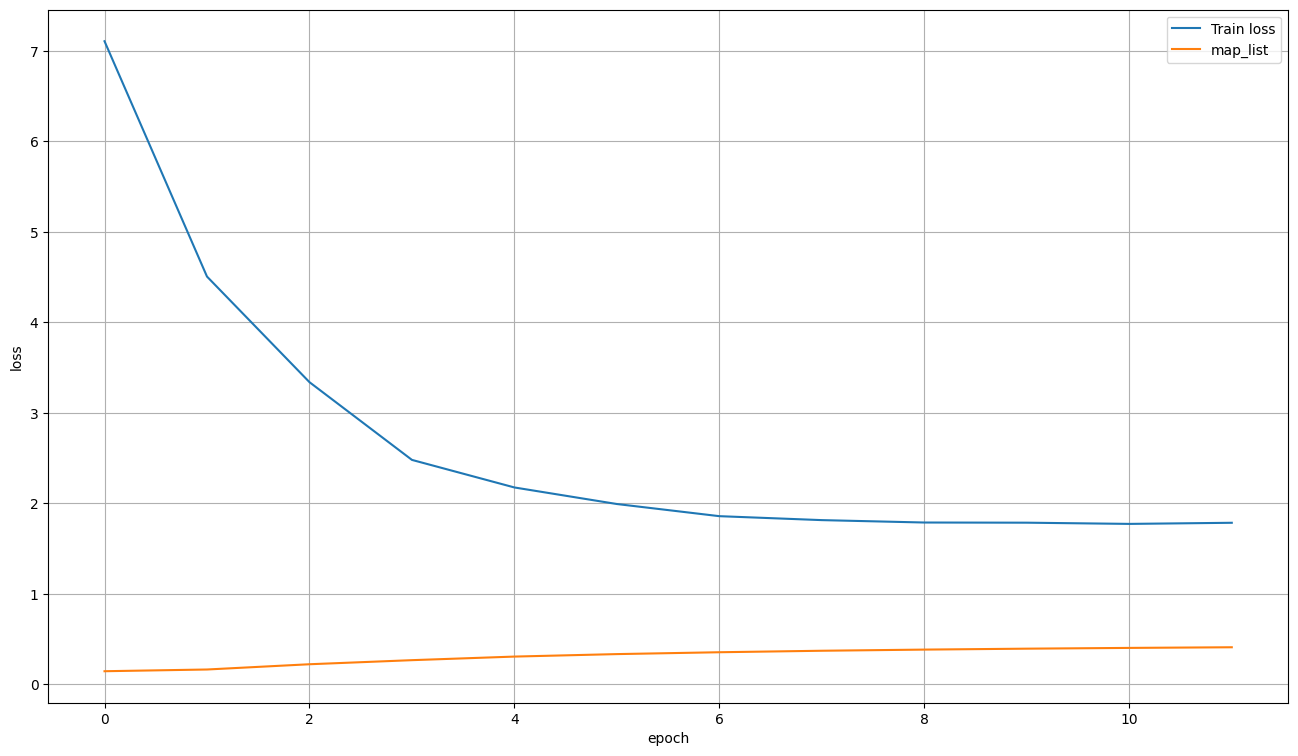

In [ ]:
plot_history(train_loss_ssd, map_list_ssd)

In [ ]:
metric_test(model_ssd, test_loader_SSD)

Test mAP: 0.5018555521965027


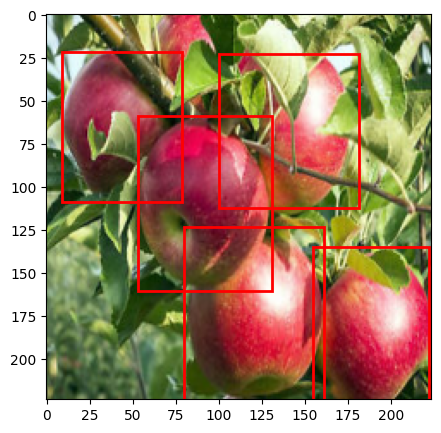

In [ ]:
images, targets = next(iter(test_loader_RCNN))
plot_img_bbox(images[0], targets[0])

In [ ]:
model_ssd.to(device)
model_ssd.eval()
with torch.no_grad():
    prediction_ssd = model_ssd([images[0].to(device)])

In [ ]:
filtered_preds_ssd = apply_threshold_batch(prediction_ssd, threshold=0.5)

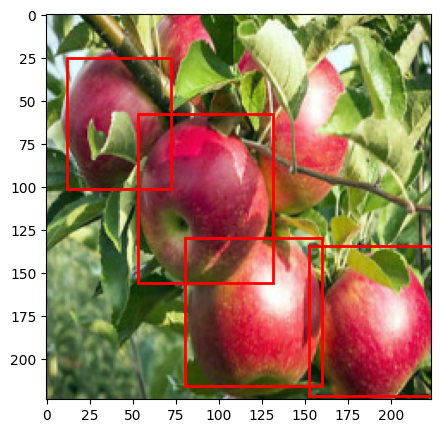

In [ ]:
plot_img_bbox(images[0], filtered_preds_ssd[0])

### 6. Измерение качества работы модели (метрики согласуются с руководителем и зависят от задачи) (2 балла)
Под метриками понимаются функции/формулы, по которым оценивается качество модели-детектора. Обычно для измерения качества работы детектора используют поклассовые Precision, Recall, F1-меру и mean Average Precision (mAP). Подробнее про них можно послушать в [видеолекции 2018 года](https://www.youtube.com/watch?v=ewkSI2cuyoQ&list=PL0Ks75aof3ThkitsZbUOEQg7Ybl5kB_s3&index=24).

**Необходимо самостоятельно реализовать требуемые метрики!**

> Результат пункта --- реализованные функции метрик для задачи детектирования, позволяющие оценить качество работы модели на выборке, а также оценка обеих обученных моделей по данным метрикам на test. Необходимо сделать вывод о том, какая модель сработала лучше и оценить полученный результат.

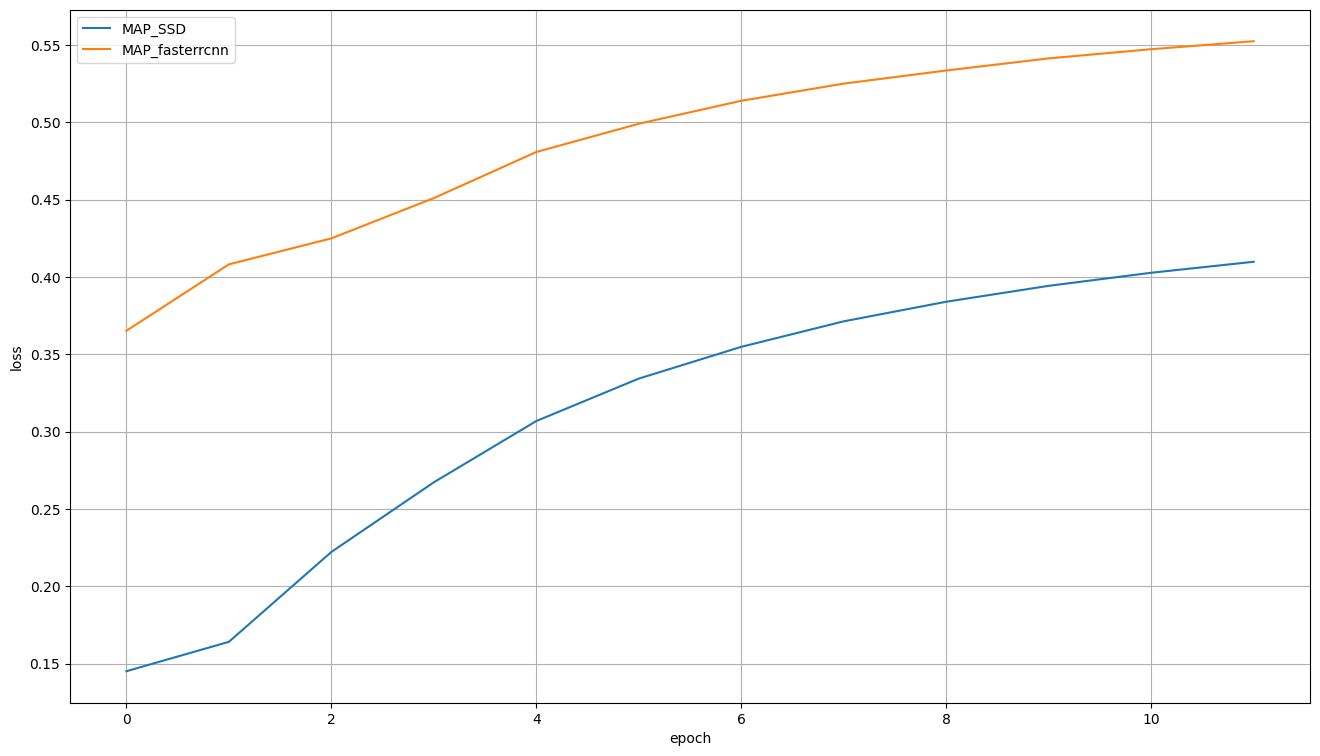

In [ ]:
plt.figure(figsize=(16,9))
plt.grid(True)
plt.plot(map_list_ssd, label='MAP_SSD')
plt.plot(map_list_RCNN, label='MAP_fasterrcnn')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

Обе модели показали рабочий результат, при котором происходит качественная детекция объектов. Лучшие показатели по метрике MAP показала модель faster_rcnn. Значения MAP в пределах от 0.5 до 0.6 может быть увеличенно при использование выборки с более массивным кол-вом тренировачных данных.

### 7. Поиск путей применения этой модели в бизнесе/реальных задачах/набросок встраивания в веб/мобильное демо (1 балл)

В этом пункте нужно подумать, как эта модель может быть использована в дальнейшем. То есть, например, зачем нужно детектировать фрукты? Или одежду?

> Результат пункта $-$ перечисленные кейсы использования модели (описанные **как можно подробнее**).

**IMPORTANT NOTE:** Обычно этим вопросом все же задаются до начала какой-либо разработки. Но поскольку проект носит учебный/исследовательский характер, допустимо говорить об этом в конце

Данный машинный алгоритм может применяться в следующих направлениях:

1) Уборка урожая. В последнее время наблюдается тенденция к уменьшению кол-ва рабочей силы в сфере сельского хозяйства. Поэтому предлагается замена людей в виде использования алгоритмов машинного обучения на роботах для определения типа фрукта, его цвета, формы и дальнейшего принятия решения о необходимости сбора урожая;

2) Интелектуальная сортировка фруктов. Устанавливается камера над конвейрной лентной. Модель определяет тип фрукта, его расположение и специальный механизм на основе полученной информации будет сортировать фрукты по требуемым ячейкам.

3) Когда кассир спрашивает: "Какой сорт яблок вы взяли?", а вы не знаете названия сорта. И для того, чтобы не заставлять людей идти к прилавку и узнавать название, система будет сама определять сорт яблок непосредственно на кассе.
